### alpha-LMS
Testing least mean squares filter on seizure data.

Reference: https://en.wikipedia.org/wiki/Least_mean_squares_filter

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [75]:
%run scripts/LMS.py
%run scripts/readEDF.py
# need to organize data
# key = patient
# row = time point
# col = n columns of raw data, 1 id column (seizure or not)

# Load patient data for one patient
# df = read_patient_edf('chb01')
# df = {}
df['chb01_03'] = read_single_edf('chb01_03') 

### Butterworth filter doesn't do anything


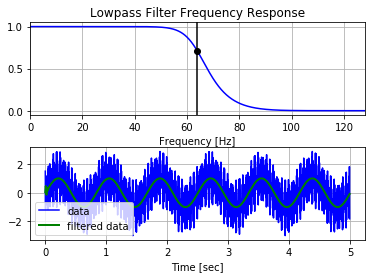

In [35]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 256       # sample rate, Hz
cutoff = 64  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(120*2*np.pi*t) + 0.5*np.sin(100*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

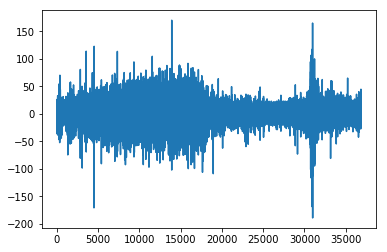

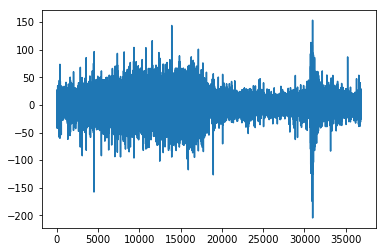

In [42]:
df[df.keys()[0]].head()
temp = df[df.keys()[0]].as_matrix()
y_raw = np.mean(temp[:,3:], axis=1)
plt.plot(y_raw[::25])
plt.show()

# Filter requirements butterworth
order = 60
fs = 256.0       # sample rate, Hz
cutoff = 64.0 # desired cutoff frequency of the filter, Hz

y_filter = butter_lowpass_filter(y_raw, cutoff, fs, order)
plt.plot(y_filter[::25])
plt.show()

### FIR Filter


In [95]:
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show

def FIR_filter(x, sample_rate = 256.0, cutoff_hz = 64.0, ripple_db = 20.0, width = 4.0):
    # The Nyquist rate of the signal.
    nyq_rate = sample_rate / 2.0

    # The desired width of the transition from pass to stop,
    # relative to the Nyquist rate.  We'll design the filter
    # with a 5 Hz transition width.
    width = width/nyq_rate

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

    # Use lfilter to filter x with the FIR filter.
    x_filter = lfilter(taps, 1.0, x)
    return x_filter

def low_pass_filter_data(df_dict, use_filter=False):
    df_avg = dict(df_dict)
    seizure_key = []
    for key in df_avg.keys():
        df_temp = df_avg[key].as_matrix()
        x = df_temp[:,3:]
        x = np.mean(x, axis=1)
        # filter x
        if use_filter:
            x = FIR_filter(x)
        y = np.copy(x)
        x = x[0:-1]
        y = y[1:]
        seizure = df_temp[:,1][0:-1]
        df_new = np.vstack([y,x,seizure]).T
        if max(df_temp[:,1]) == 1:
            seizure_key.append(key)
        df_avg[key] = df_new
    return df_avg

In [96]:
%run scripts/LMS.py
df_avg_filter = low_pass_filter_data(df, use_filter=True)
eeg_mu_LMS = mu_LMS_filter(df_avg_filter, mu_fraction=0.001, num_weight=512, bias=True, causal=True, delay=0)
key = df_avg_filter.keys()[0] # seizure_key[0]
# weight_path, predicted, error_path = eeg_mu_LMS.train_single_eeg(key, train_cycles=10)
eeg_mu_LMS.train(num_repeat=1)

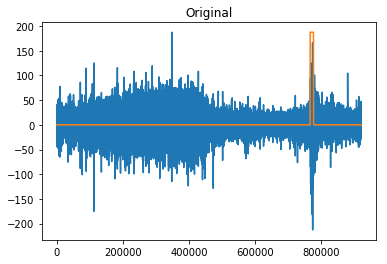

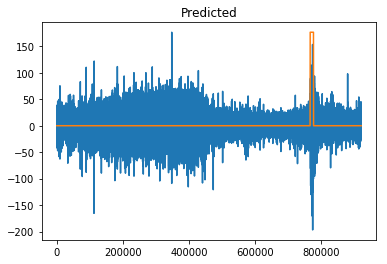

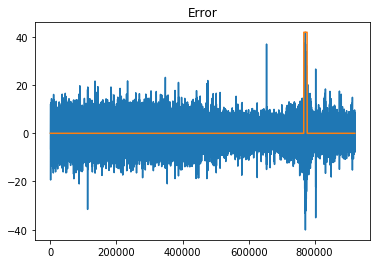

In [97]:
predicted, error = eeg_mu_LMS.apply_filter(df_avg_filter[key][:,1], output = df_avg_filter[key][:,0])
original = df_avg_filter[key][:,1]
seizure = df_avg_filter[key][:,2]

plt.figure()
plt.plot(original)
plt.plot(seizure*max(original[~np.isnan(original)]))
plt.title('Original')
plt.figure()
plt.plot(predicted)
plt.plot(seizure*max(predicted[~np.isnan(predicted)]))
plt.title('Predicted')
plt.show()
plt.figure()
plt.plot(error)
plt.plot(seizure*max(error[~np.isnan(error)]))
plt.title('Error')
plt.show()

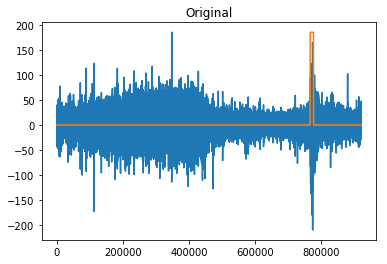

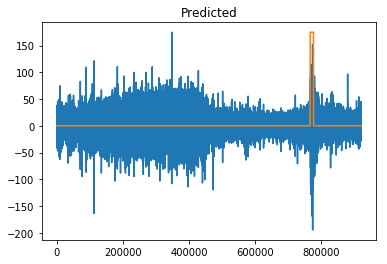

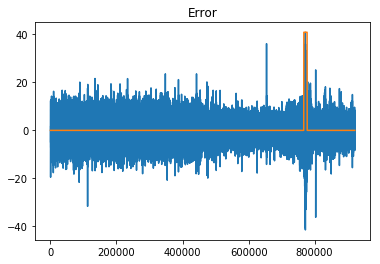

In [92]:
predicted, error = eeg_mu_LMS.apply_filter(df_avg_filter[key][:,1], output = df_avg_filter[key][:,0])
original = df_avg_filter[key][:,1]
seizure = df_avg_filter[key][:,2]

plt.figure()
plt.plot(original)
plt.plot(seizure*max(original[~np.isnan(original)]))
plt.title('Original')
plt.figure()
plt.plot(predicted)
plt.plot(seizure*max(predicted[~np.isnan(predicted)]))
plt.title('Predicted')
plt.show()
plt.figure()
plt.plot(error)
plt.plot(seizure*max(error[~np.isnan(error)]))
plt.title('Error')
plt.show()

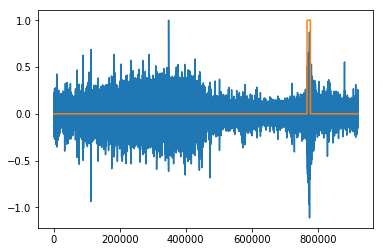

In [60]:
# plt.figure()
# plt.plot(weight_path[::256,0:10])
# plt.show()

predicted = eeg_mu_LMS.apply_filter(df_avg['1'][:,1])
plt.figure()
plt.plot(predicted/max(predicted[~np.isnan(predicted)]))
plt.plot(df.as_matrix()[:,1])
plt.show()